Nama Anggota :

1. Alfiyul Akyun - 2041720036
2.   Nurlaily Asrobika - 2041720172



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import absolute_import, print_function, division, unicode_literals
import os.path
import glob
import shutil

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense, Activation
from keras import regularizers
import keras

import numpy as np
import matplotlib.pyplot as plt
import pathlib

from skimage.feature import corner_harris, corner_peaks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
data_dir = "/content/drive/MyDrive/PCVK_MM/Images/Rice Leaf Disease/"
data_dir = pathlib.Path(data_dir)

In [ ]:
CLASS_NAMES = np.array(['Leaf Blight', 'Brown Spot', 'Leaf Smut'])

print('Class Names:', CLASS_NAMES)

Class Names: ['Leaf Blight' 'Brown Spot' 'Leaf Smut']


In [ ]:
train_path = '/content/drive/MyDrive/PCVK_MM/Images/Rice Leaf Disease/'
test_path = '/content/drive/MyDrive/PCVK_MM/Images/Rice Leaf Disease/'

In [ ]:
image_train_gen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.50,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15)

train_data_gen = image_train_gen.flow_from_directory(train_path,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='sparse')

img_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = img_val_gen.flow_from_directory(test_path,
                                               batch_size=BATCH_SIZE,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='sparse')


Found 120 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90:
            print('\nAkurasi mencapai 90%')
        print(f"Epoch {epoch+1} - Loss: {logs['loss']:.4f} - Accuracy: {logs['accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f}")

callbacks = myCallback()

In [ ]:
def plotImages(image_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

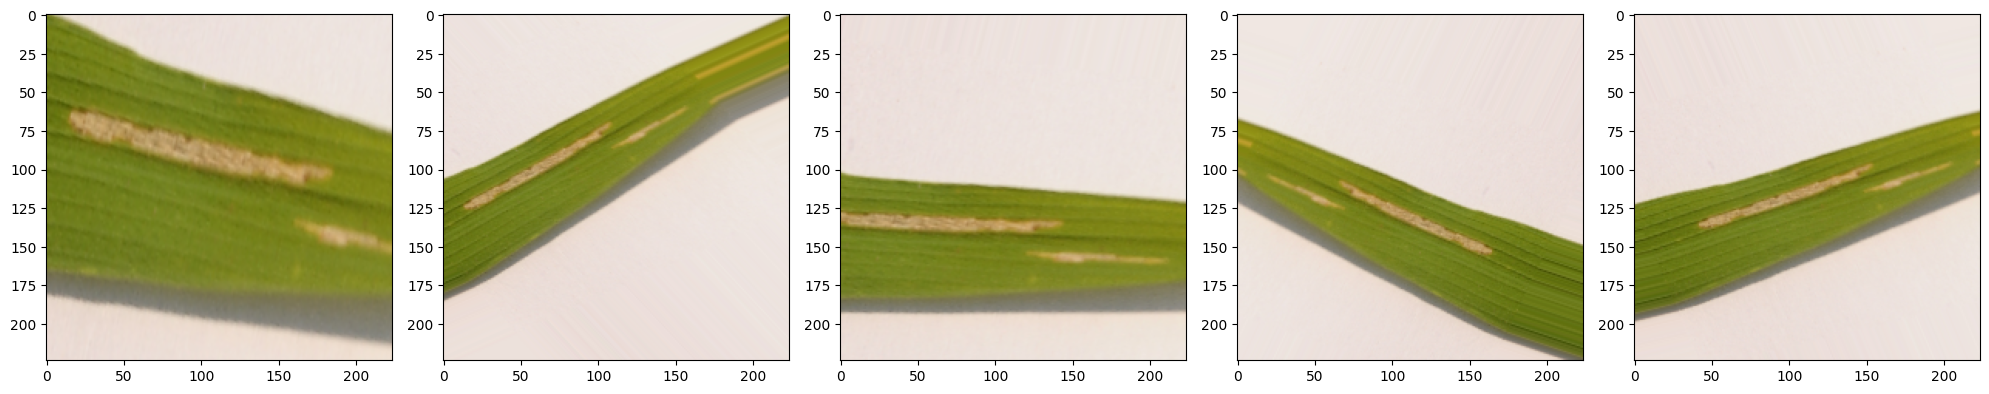

In [ ]:
# Plot a few training images
img_array = [train_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

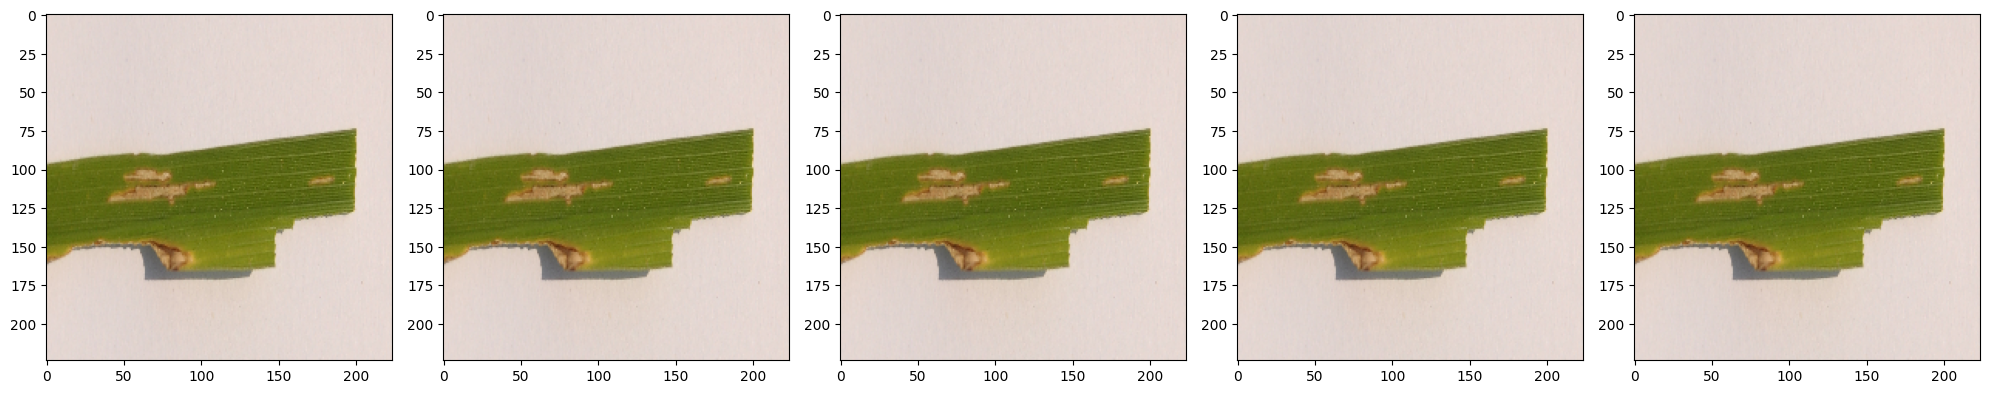

In [ ]:
# Plot a few validations images
img_array = [val_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

#**Ekstraksi Fitur**

In [ ]:
def extract_features(image):
    gray = tf.image.rgb_to_grayscale(image)
    gray = tf.squeeze(gray)
    corners = corner_peaks(corner_harris(gray), min_distance=5)
    return corners.shape[0]

In [ ]:
# Prepare training data
X_train = []
y_train = []

for images, labels in train_data_gen:
    for i in range(len(images)):
        features = extract_features(images[i])
        X_train.append(features)
        y_train.append(labels[i])

    if len(X_train) >= len(train_data_gen.classes):
        break

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# Prepare validation data
X_val = []
y_val = []

for images, labels in val_data_gen:
    for i in range(len(images)):
        features = extract_features(images[i])
        X_val.append(features)
        y_val.append(labels[i])

    if len(X_val) >= len(val_data_gen.classes):
        break

X_val = np.array(X_val)
y_val = np.array(y_val)

#**Training**

In [ ]:
# Train K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=3) # menentukan jumlah neighbors terdekat yang akan digunakan untuk melakukan klasifikasi.
knn.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1)) # mengubah fitur menjadi bentuk dengan 1 kolom,

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Evaluate on validation data
val_predictions = knn.predict(X_val.reshape(-1, 1)) # Baris ini memprediksi kelas target (variabel dependen) pada data validasi (X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

In [ ]:
# Model building
# Instantiating a convnet
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(224, 224, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 64)      

In [ ]:
#  menginisialisasi pelatihan model dengan data generator.

EPOCHS = 70# mendefinisikan jumlah EPOCHS atau iterasi yang akan dilakukan selama proses pelatihan. Setiap EPOCHS akan melibatkan pemrosesan seluruh dataset pelatihan.
history = model.fit_generator(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen, callbacks=[callbacks]) #  menjalankan proses pelatihan pada model menggunakan data generator.

<ipython-input-51-d029a273cd6f>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen, callbacks=[callbacks]) #  menjalankan proses pelatihan pada model menggunakan data generator.


Epoch 1/70
15/15 [==============================] - 24s 1s/step - loss: 1.3240 - accuracy: 0.3750 - val_loss: 1.0400 - val_accuracy: 0.4583
Epoch 2/70
15/15 [==============================] - 23s 2s/step - loss: 1.0458 - accuracy: 0.4167 - val_loss: 0.9645 - val_accuracy: 0.5167
Epoch 3/70
15/15 [==============================] - 24s 2s/step - loss: 0.9995 - accuracy: 0.5417 - val_loss: 0.9612 - val_accuracy: 0.5083
Epoch 4/70
15/15 [==============================] - 23s 2s/step - loss: 1.1080 - accuracy: 0.4583 - val_loss: 1.0117 - val_accuracy: 0.6000
Epoch 5/70
15/15 [==============================] - 23s 2s/step - loss: 0.9922 - accuracy: 0.5583 - val_loss: 0.9925 - val_accuracy: 0.5333
Epoch 6/70
15/15 [==============================] - 19s 1s/step - loss: 1.0000 - accuracy: 0.5083 - val_loss: 0.7953 - val_accuracy: 0.6833
Epoch 7/70
15/15 [==============================] - 18s 1s/step - loss: 0.8694 - accuracy: 0.5750 - val_loss: 0.7765 - val_accuracy: 0.7000
Epoch 8/70
15/15 [==

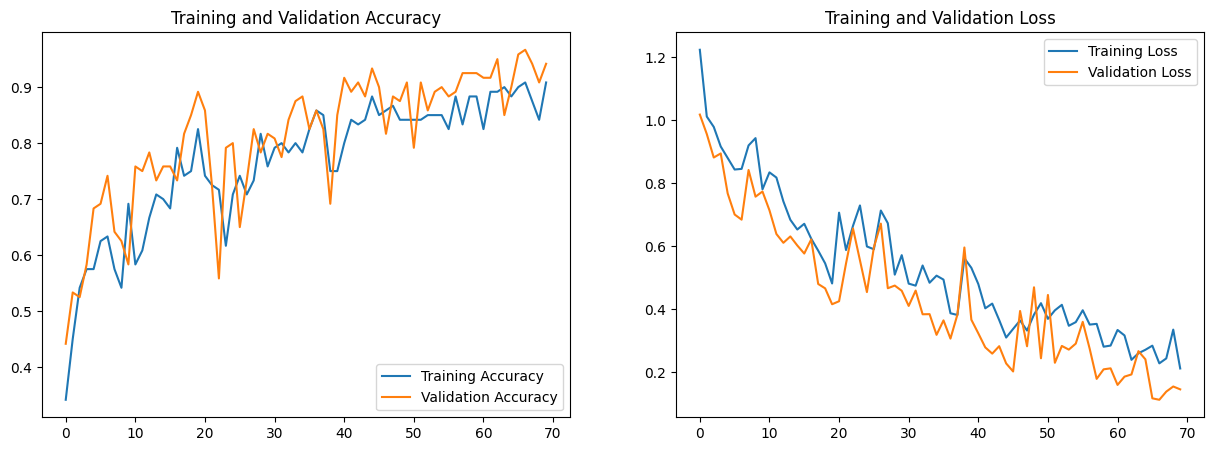

In [ ]:
# Plot training and validation graphs
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return img_array

In [ ]:
def predict_image_class(image_array):
    features = extract_features(image_array)
    prediction = knn.predict([features])
    return prediction

Saving DSC_0108.jpg to DSC_0108.jpg
1/1 [==============================] - 0s 68ms/step


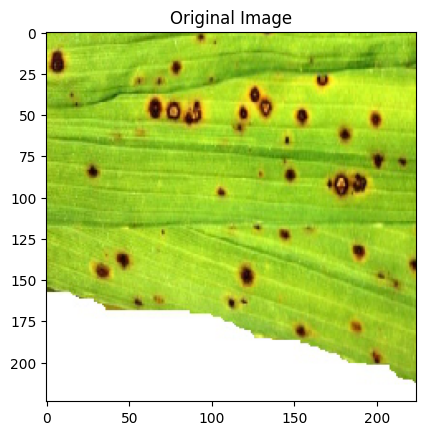

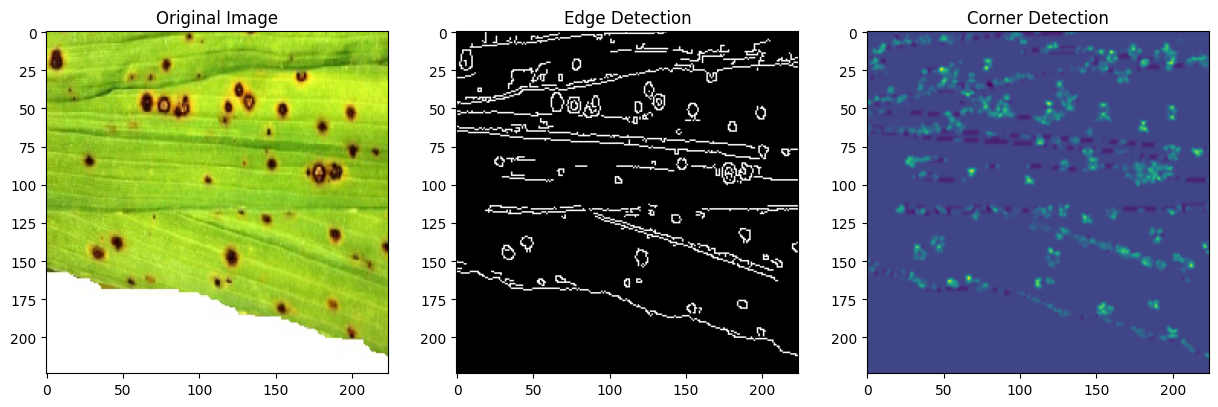

DSC_0108.jpg
This image belongs to class: Brown Spot


In [ ]:
from google.colab import files
import cv2 # mengimpor modul OpenCV yang digunakan untuk operasi pengolahan citra.
from tensorflow.keras.preprocessing import image
uploaded = files.upload() # mengunggah gambar yang akan diproses.

for fn in uploaded.keys(): # memulai loop untuk setiap gambar yang diunggah.
    # Preprocess and predict image class
    img = image.load_img(fn, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_resized = img_array / 255.0
    image_array = np.expand_dims(img_resized, axis=0)

    prediction = model.predict(image_array)
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = CLASS_NAMES[predicted_class_index]

    # Display image and predicted class
    imgplot = plt.imshow(img)
    plt.title('Original Image')
    plt.show()

    # Convert PIL image to OpenCV format
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Edge Detection
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    # Corner Detection
    corners = corner_harris(edges)

    # Display the original image, edges, and corners
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[1].imshow(edges, cmap='gray')
    axes[1].set_title('Edge Detection')
    axes[2].imshow(corners)
    axes[2].set_title('Corner Detection')
    plt.show()

    print(fn)
    print('This image belongs to class:', predicted_class)

